<a href="https://colab.research.google.com/github/Trev621/GenAI/blob/main/HW3/problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Trevor Lacoste
The purpose of this assignment is to create and train a Variational Autoencoder (VAE) model in Keras to learn representations of the Street View House Numbers (SVHN) dataset and explore its performance with different latent dimensions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

## 1. Load and Preprocess the SVHN Dataset

In [4]:
#Download training and test set
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-10 03:16:19--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M   364KB/s    in 5m 46s  

2024-10-10 03:22:05 (514 KB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-10 03:22:05--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M   349KB/s    in 2m 49s  

2024-10-10 03:24:55 (370 KB/s) - ‘test_32x32.mat’ saved [64275384/6427

In [5]:
#Load the data
from scipy.io import loadmat

#Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

#Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

#Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


## 2. Build the Variational Autoencoder <a name="build"></a>

In [6]:
#Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
#Encoder
def build_encoder(latent_dim):
  #Input has 3 color channels
  encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input")

  #Convolutional Layers
  x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
  x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

  shape_before_flattening = K.int_shape(x)[1:] #For the decoder
  x = layers.Flatten()(x) #Flatten the 2D maps to 1D before dense layers

  #Latent space that uses given dimensions
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

  #Sample from the distribution
  z = Sampling()([z_mean, z_log_var])

  encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
  return encoder, shape_before_flattening

In [8]:
# Decoder
def build_decoder(latent_dim, shape_before_flattening):
  #Input is the dimensions of the latent space
  decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")

  x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) #Dense layer
  x = layers.Reshape(shape_before_flattening)(x) #Rearranges data according to specified shape

  #Transpose layers to increase size of the feature map
  x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

  #Images are RGB so number of filters is 3
  decoder_output = layers.Conv2D(3, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output",)(x)

  decoder = models.Model(decoder_input, decoder_output)
  return decoder

In [9]:
#VAE class from given example
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            500
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [10]:
#Create the VAE
def build_vae(latent_dim):
  encoder, shape_before_flattening = build_encoder(latent_dim)
  decoder = build_decoder(latent_dim, shape_before_flattening)
  vae = VAE(encoder, decoder)
  vae_input = encoder.input
  vae_output = decoder(encoder(vae_input)[2])
  vae = models.Model(vae_input, vae_output, name = "vae")
  return vae

## 3. Train the VAE with different latent dimensions <a name="train"></a>

In [11]:
#Training with different latent dimensions
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, x_train, epochs=100, batch_size=64, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Epoch 1/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.6476 - val_loss: 0.6138
Epoch 2/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6343 - val_loss: 0.6126
Epoch 3/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6339 - val_loss: 0.6127
Epoch 4/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6333 - val_loss: 0.6126
Epoch 5/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6328 - val_loss: 0.6126
Epoch 6/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6334 - val_loss: 0.6133
Epoch 7/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6329 - val_loss: 0.6129
Epoch 8/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6334 - val_loss: 0.6132
Epoch 9/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6324 - val_loss: 0.6129
Epoch 10/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.6326 - val_loss: 0.6126
Epoch 11/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 

In [12]:
#Evaluate the models performance
print("Total loss: ", vae.evaluate(x_test, x_test))

814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5940
Total loss:  0.5935698747634888


## 4. Visualize the results <a name="reconstruct"></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


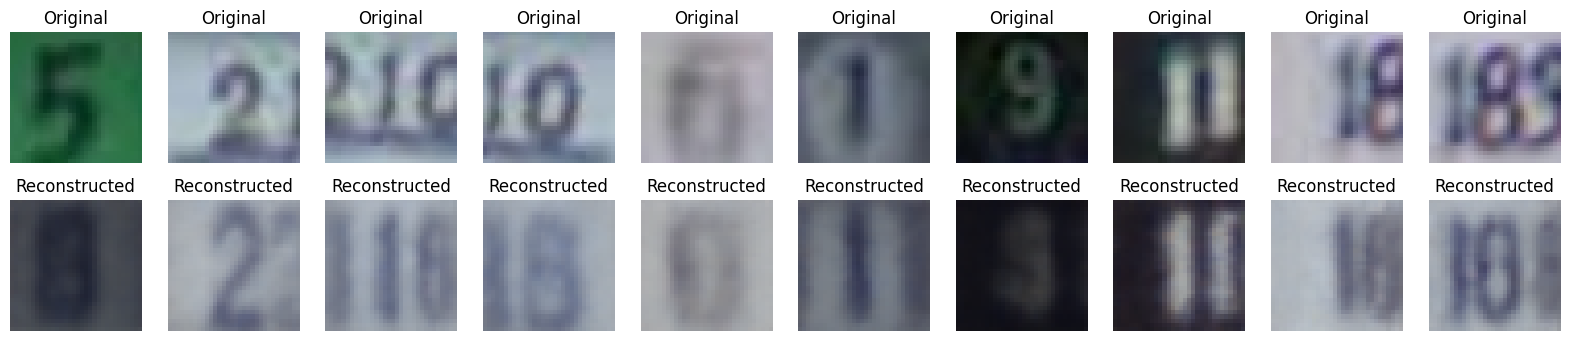

In [14]:
#Comparing original to reconstructed images
def plot_reconstructions(vae, x_test, n=10):
    reconstructions = vae.predict(x_test[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        #Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis("off")

        #Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.show()

plot_reconstructions(vae, x_test)

# Discussion Points


*   **Clarity**: Most reconstructed images are recognizable as the same digit as the original. In some cases, like the first image, the reconstructed image contains a wrong digit. The model reconstructed an eight when the original digit is a five. This means that the model sometimes struggles with similar structures of digits.
*   **Distortion**: For the most part, the reconstructed images have about the same level of detail as the original. The original images themselves are not very clear, so the reconstructed images are not significantly distorted.
*   **Variability**: The model performs better when the digit and the background are distinct colors. For example, with the seventh and eighth images, the VAE can reconstruct the images reasonably well because the digit is white and the background is black. With images one and five, the reconstructed image is not as clear since the colors of the digit and background are similar. When it comes to the font of the digit, it doesn't seem to have much of an effect.
*   **Generalization**: When the VAE is reconstructing images of clear digits with a distinct background, the model is good at reconstructing an accurate representation with decent clarity. With other images that are already distorted or the number is cut off, the model fails to reconstruct a fully accurate image.




